# Web User Behavior Analysis and Machine Learning Model Development

This Jupyter notebook aims to analyze web user behavior by processing Nginx log data (`access.log`) and client hostname information (`client_hostname.csv`). We will perform data cleaning, preprocessing, exploratory data analysis, and build a machine learning model to understand user actions such as:

- Viewing products
- Adding products to the cart but not purchasing (wishlist behavior)
- Purchasing products

The notebook includes detailed code, mathematical explanations, and visualizations to support your research.



## 1. Install Required Libraries

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
%matplotlib inline 

## Data Loading and Preprocessing

In [3]:
import os
print(os.getcwd())


/Users/abhishekkandel


In [4]:
os.chdir('/Users/abhishekkandel/Desktop/LOG Analysis/')
print(os.getcwd())

/Users/abhishekkandel/Desktop/LOG Analysis


In [5]:
# Function to parse each log line:
def parse_log_line(line):
    match = re.match(log_pattern, line)
    if match:
        return match.groupdict()
    else:
        return None

In [6]:
# Define the log pattern
log_pattern = r'(?P<ip>\S+) - - \[(?P<time>[^\]]+)\] "(?P<request>[^"]+)" (?P<status>\d{3}) (?P<size>\S+) "(?P<referer>[^"]*)" "(?P<user_agent>[^"]*)"'

# Read and parse the log file:
chunk_size = 100000  # Adjust based on your system's memory
df_list = []

with open('access.log', 'r', encoding='utf-8', errors='ignore') as file:
    batch = []
    for idx, line in enumerate(file):
        parsed_line = parse_log_line(line)
        if parsed_line:
            batch.append(parsed_line)
        if (idx + 1) % chunk_size == 0:
            temp_df = pd.DataFrame(batch)
            df_list.append(temp_df)
            batch = []
    if batch:
        temp_df = pd.DataFrame(batch)
        df_list.append(temp_df)
print(f"Number of dataframes: {len(df_list)}")
print(f"Number of rows: {sum([len(df) for df in df_list])}")
print(f"Columns: {df_list[0].columns}")
print(df_list[0].head())

# Combine all dataframes
logs_df = pd.concat(df_list, ignore_index=True)
print(f"Combined dataframe shape: {logs_df.shape}")
print(logs_df.head())


# Importing the the prased_access_log.csv file
df = pd.read_csv('parsed_access_log.csv')
df.head()



Number of dataframes: 104
Number of rows: 10365144
Columns: Index(['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'], dtype='object')
              ip                        time  \
0   54.36.149.41  22/Jan/2019:03:56:14 +0330   
1    31.56.96.51  22/Jan/2019:03:56:16 +0330   
2    31.56.96.51  22/Jan/2019:03:56:16 +0330   
3  40.77.167.129  22/Jan/2019:03:56:17 +0330   
4    91.99.72.15  22/Jan/2019:03:56:17 +0330   

                                             request status   size  \
0  GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...    200  30577   
1     GET /image/60844/productModel/200x200 HTTP/1.1    200   5667   
2     GET /image/61474/productModel/200x200 HTTP/1.1    200   5379   
3     GET /image/14925/productModel/100x100 HTTP/1.1    200   1696   
4  GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...    200  41483   

                               referer  \
0                                    -   
1  https://www.zanbil.ir/m/filter/b113   
2  https://w

,ip,time,request,status,size,referer,user_agent,method,url,protocol,date,hour
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%D...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,HTTP/1.1,2019-01-22,3
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/60844/productModel/200x200 HTTP/1.1,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,GET,/image/60844/productModel/200x200,HTTP/1.1,2019-01-22,3
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET /image/61474/productModel/200x200 HTTP/1.1,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,GET,/image/61474/productModel/200x200,HTTP/1.1,2019-01-22,3
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET /image/14925/productModel/100x100 HTTP/1.1,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,GET,/image/14925/productModel/100x100,HTTP/1.1,2019-01-22,3
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET /product/31893/62100/%D8%B3%D8%B4%D9%88%D8...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,HTTP/1.1,2019-01-22,3


In [7]:
# Load Client Hostname Data
client_df = pd.read_csv('client_hostname.csv')
print(client_df.head())

          client                 hostname                      alias_list  \
0   5.123.144.95             5.123.144.95          [Errno 1] Unknown host   
1   5.122.76.187             5.122.76.187          [Errno 1] Unknown host   
2   5.215.249.99             5.215.249.99          [Errno 1] Unknown host   
3  31.56.102.211  31-56-102-211.shatel.ir  ['211.102.56.31.in-addr.arpa']   
4  5.123.166.223            5.123.166.223          [Errno 1] Unknown host   

        address_list  
0                NaN  
1                NaN  
2                NaN  
3  ['31.56.102.211']  
4                NaN  


## 3. Data Preprocessing


In [8]:
# Check if 'time' column exists
print(logs_df.columns)

if 'time' not in logs_df.columns:
	print("Column 'time' does not exist in logs_df. Using data from parsed_access_log.csv.")
	logs_df = df.copy()
	logs_df['time'] = pd.to_datetime(logs_df['time'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce')
else:
	# Convert timestamp to datetime:
	logs_df['time'] = pd.to_datetime(logs_df['time'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')

print(logs_df['time'].head())

Index(['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'], dtype='object')
0   2019-01-22 03:56:14+03:30
1   2019-01-22 03:56:16+03:30
2   2019-01-22 03:56:16+03:30
3   2019-01-22 03:56:17+03:30
4   2019-01-22 03:56:17+03:30
Name: time, dtype: datetime64[ns, UTC+03:30]


In [9]:
# Drop rows with invalid timestamps:
logs_df = logs_df.dropna(subset=['time'])
print(logs_df.shape)

(10365144, 7)


In [10]:
# Extract HTTP method, endpoint, and protocol from the request:
logs_df[['method', 'endpoint', 'protocol']] = logs_df['request'].str.extract(r'(\w+)\s+(\S+)\s+(\S+)')
print(logs_df[['method', 'endpoint', 'protocol']].head())


  method                                           endpoint  protocol
0    GET  /filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...  HTTP/1.1
1    GET                  /image/60844/productModel/200x200  HTTP/1.1
2    GET                  /image/61474/productModel/200x200  HTTP/1.1
3    GET                  /image/14925/productModel/100x100  HTTP/1.1
4    GET  /product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...  HTTP/1.1


In [11]:
# Converting status and size to numeric:
logs_df['status'] = pd.to_numeric(logs_df['status'], errors='coerce')
logs_df['size'] = logs_df['size'].replace('-', '0')
logs_df['size'] = pd.to_numeric(logs_df['size'], errors='coerce')
print(logs_df[['status', 'size']].dtypes)
print(logs_df[['status', 'size']].head())
print(logs_df[['status', 'size']].describe())
print(logs_df['status'].value_counts())
print(logs_df['size'].value_counts())
print(logs_df['size'].describe())
print(logs_df['size'].value_counts().head())
print(logs_df['size'].value_counts().tail())
print(logs_df['size'].value_counts().sort_index().head())
print(logs_df['size'].value_counts().sort_index().tail())




status    int64
size      int64
dtype: object
   status   size
0     200  30577
1     200   5667
2     200   5379
3     200   1696
4     200  41483
             status          size
count  1.036514e+07  1.036514e+07
mean   2.101418e+02  1.243312e+04
std    3.921397e+01  2.812655e+04
min    2.000000e+02  0.000000e+00
25%    2.000000e+02  2.027000e+03
50%    2.000000e+02  4.120000e+03
75%    2.000000e+02  1.155100e+04
max    5.040000e+02  1.249490e+06
status
200    9579825
304     340228
302     199835
404     105011
301      67551
499      50852
500      14266
403       5634
502        798
400        580
401        323
408        112
504        103
414         17
405          6
206          3
Name: count, dtype: int64
size
0         770611
4120      351227
11        247643
28536     113757
323       102800
           ...  
14626          1
280776         1
276441         1
49066          1
9019           1
Name: count, Length: 69707, dtype: int64
count    1.036514e+07
mean     1.243312e

In [12]:
# Fill missing values and drop unnecessary columns:
logs_df['referer'] = logs_df['referer'].fillna('Unknown')
logs_df['user_agent'] = logs_df['user_agent'].fillna('Unknown')
logs_df = logs_df.drop(columns=['request'])
print(logs_df.head())
print(logs_df.isnull().sum())
print(logs_df.dtypes)

              ip                      time  status   size  \
0   54.36.149.41 2019-01-22 03:56:14+03:30     200  30577   
1    31.56.96.51 2019-01-22 03:56:16+03:30     200   5667   
2    31.56.96.51 2019-01-22 03:56:16+03:30     200   5379   
3  40.77.167.129 2019-01-22 03:56:17+03:30     200   1696   
4    91.99.72.15 2019-01-22 03:56:17+03:30     200  41483   

                               referer  \
0                                    -   
1  https://www.zanbil.ir/m/filter/b113   
2  https://www.zanbil.ir/m/filter/b113   
3                                    -   
4                                    -   

                                          user_agent method  \
0  Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...    GET   
1  Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...    GET   
2  Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...    GET   
3  Mozilla/5.0 (compatible; bingbot/2.0; +http://...    GET   
4  Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...    GET   

 

In [13]:
# 3.2 Merge with Client Hostname Data
merged_df = logs_df.merge(client_df, left_on='ip', right_on='client', how='left')
print(merged_df.head())
print(merged_df.isnull().sum())
print(merged_df.dtypes)


              ip                      time  status   size  \
0   54.36.149.41 2019-01-22 03:56:14+03:30     200  30577   
1    31.56.96.51 2019-01-22 03:56:16+03:30     200   5667   
2    31.56.96.51 2019-01-22 03:56:16+03:30     200   5379   
3  40.77.167.129 2019-01-22 03:56:17+03:30     200   1696   
4    91.99.72.15 2019-01-22 03:56:17+03:30     200  41483   

                               referer  \
0                                    -   
1  https://www.zanbil.ir/m/filter/b113   
2  https://www.zanbil.ir/m/filter/b113   
3                                    -   
4                                    -   

                                          user_agent method  \
0  Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...    GET   
1  Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...    GET   
2  Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...    GET   
3  Mozilla/5.0 (compatible; bingbot/2.0; +http://...    GET   
4  Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...    GET   

 

## 4. Exploratory Data Analysis (EDA)



In [14]:
# First few rows of the data:
merged_df.head()

,ip,time,status,size,referer,user_agent,method,endpoint,protocol,client,hostname,alias_list,address_list
0,54.36.149.41,2019-01-22 03:56:14+03:30,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,HTTP/1.1,54.36.149.41,54.36.149.41,[Errno 1] Unknown host,NaN
1,31.56.96.51,2019-01-22 03:56:16+03:30,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,GET,/image/60844/productModel/200x200,HTTP/1.1,31.56.96.51,31.56.96.51,[Errno 1] Unknown host,NaN
2,31.56.96.51,2019-01-22 03:56:16+03:30,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,GET,/image/61474/productModel/200x200,HTTP/1.1,31.56.96.51,31.56.96.51,[Errno 1] Unknown host,NaN
3,40.77.167.129,2019-01-22 03:56:17+03:30,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,GET,/image/14925/productModel/100x100,HTTP/1.1,40.77.167.129,40.77.167.129,[Errno 1] Unknown host,NaN
4,91.99.72.15,2019-01-22 03:56:17+03:30,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,HTTP/1.1,91.99.72.15,91.99.72.15,[Errno 1] Unknown host,NaN


In [15]:
# Summary statistics:
merged_df.describe(include='all')

,ip,time,status,size,referer,user_agent,method,endpoint,protocol,client,hostname,alias_list,address_list
count,10365144,10365144,1.036514e+07,1.036514e+07,10365144,10365144,10365075,10365075,10365075,10364915,10364322,10364915,530978
unique,258606,NaN,NaN,NaN,103238,28344,7,893048,7,258445,258273,5820,5819
top,66.249.66.194,NaN,NaN,NaN,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,GET,/settings/logo,HTTP/1.1,66.249.66.194,66.249.66.194,[Errno 1] Unknown host,['66.249.66.92']
freq,353483,NaN,NaN,NaN,1646351,746572,10189981,352047,10363928,353483,353483,9833937,88332
mean,NaN,2019-01-24 13:02:56.221652224+03:30,2.101418e+02,1.243312e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2019-01-22 03:56:14+03:30,2.000000e+02,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2019-01-23 09:32:56+03:30,2.000000e+02,2.027000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2019-01-24 12:09:06+03:30,2.000000e+02,4.120000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2019-01-25 20:22:33+03:30,2.000000e+02,1.155100e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2019-01-26 20:29:13+03:30,5.040000e+02,1.249490e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/2813827440.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=method_counts.index, y=method_counts.values, palette='viridis')


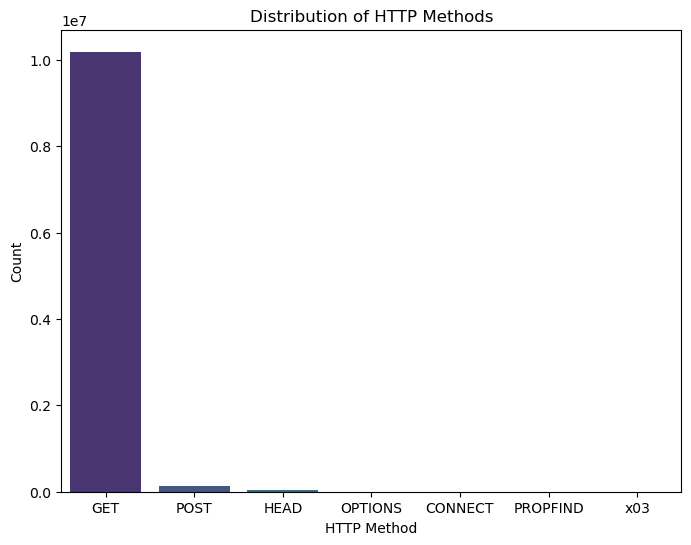

method
GET         10189981
POST          139155
HEAD           34501
OPTIONS         1424
CONNECT           10
PROPFIND           3
x03                1
Name: count, dtype: int64


In [16]:
# Distribution of HTTP methods:
method_counts = merged_df['method'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=method_counts.index, y=method_counts.values, palette='viridis')
plt.title('Distribution of HTTP Methods')
plt.xlabel('HTTP Method')
plt.ylabel('Count')
plt.show()

print (method_counts)




/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/454542276.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index.astype(str), y=status_counts.values, palette='coolwarm')


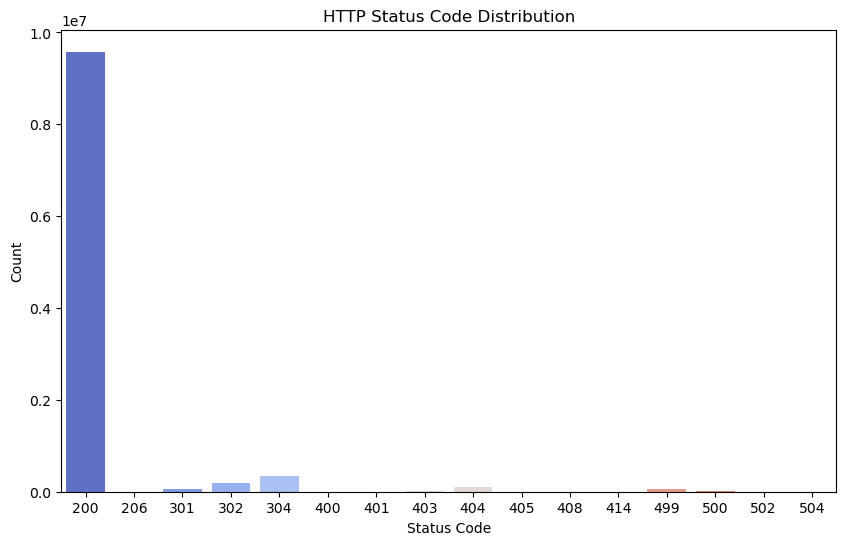

status
200    9579825
206          3
301      67551
302     199835
304     340228
400        580
401        323
403       5634
404     105011
405          6
408        112
414         17
499      50852
500      14266
502        798
504        103
Name: count, dtype: int64


In [17]:
# Status code distribution:
status_counts = merged_df['status'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=status_counts.index.astype(str), y=status_counts.values, palette='coolwarm')
plt.title('HTTP Status Code Distribution')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.show()

print(status_counts)


/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/1730166258.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_endpoints.index, x=top_endpoints.values, palette='magma')


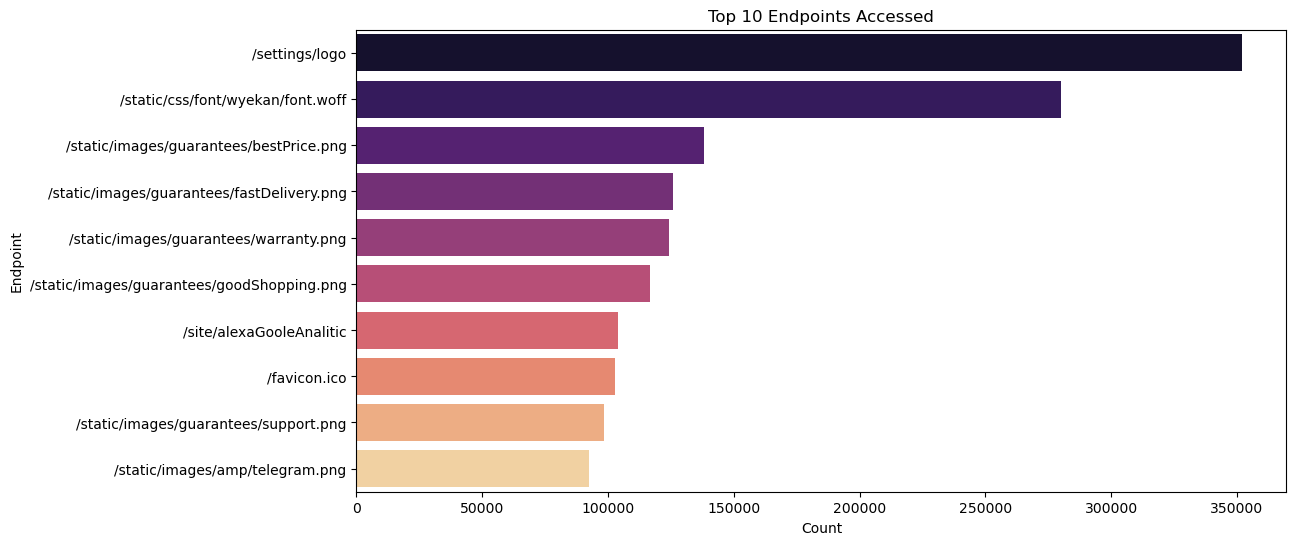

endpoint
/settings/logo                                352047
/static/css/font/wyekan/font.woff             280176
/static/images/guarantees/bestPrice.png       138010
/static/images/guarantees/fastDelivery.png    125689
/static/images/guarantees/warranty.png        124127
/static/images/guarantees/goodShopping.png    116653
/site/alexaGooleAnalitic                      103798
/favicon.ico                                  102731
/static/images/guarantees/support.png          98460
/static/images/amp/telegram.png                92409
Name: count, dtype: int64


In [18]:
# Top Endpoints Accessed
top_endpoints = merged_df['endpoint'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(y=top_endpoints.index, x=top_endpoints.values, palette='magma')
plt.title('Top 10 Endpoints Accessed')
plt.xlabel('Count')
plt.ylabel('Endpoint')
plt.show()

print(top_endpoints)

/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/3462113978.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  traffic = merged_df.resample('H').size()


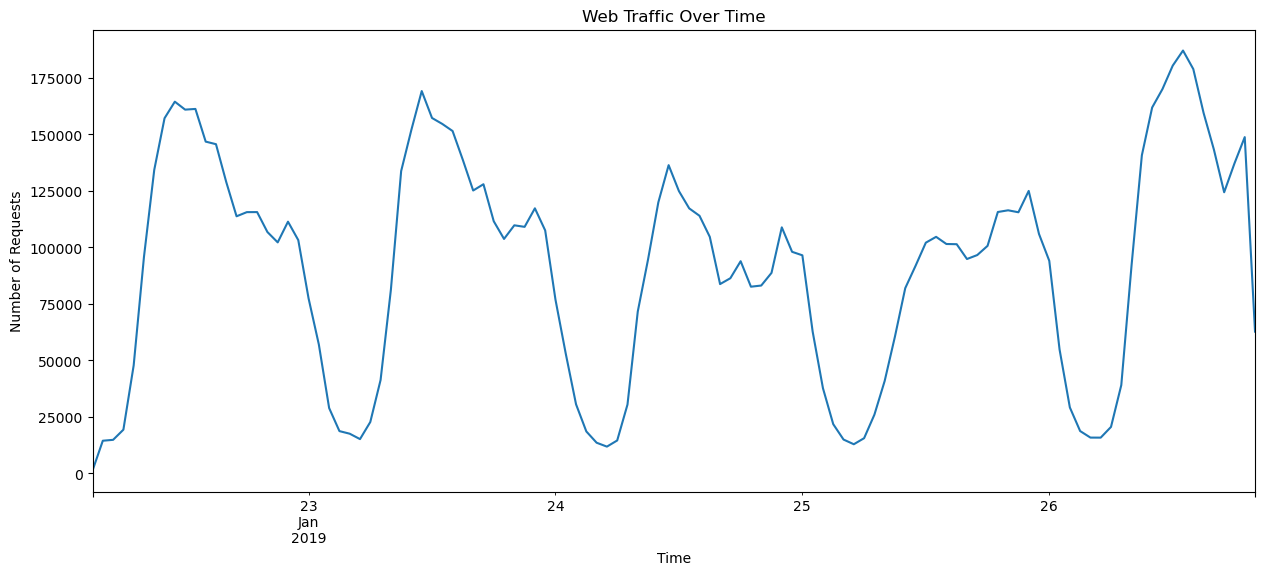

time
2019-01-22 03:00:00+03:30     1285
2019-01-22 04:00:00+03:30    14471
2019-01-22 05:00:00+03:30    14867
2019-01-22 06:00:00+03:30    19357
2019-01-22 07:00:00+03:30    47800
Freq: h, dtype: int64


/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/3462113978.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values, palette='rocket')


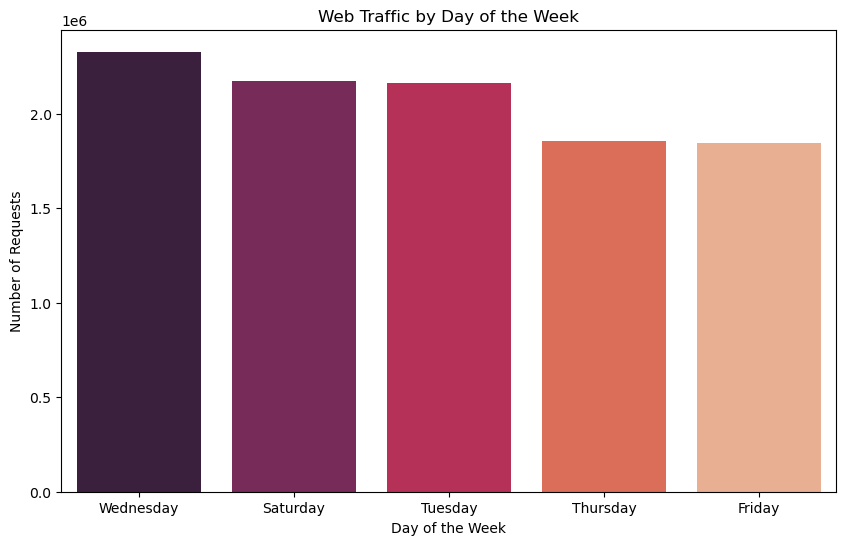

day_of_week
Wednesday    2328562
Saturday     2174497
Tuesday      2160924
Thursday     1857854
Friday       1843307
Name: count, dtype: int64


/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/3462113978.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hour_counts.index, y=hour_counts.values, palette='mako')


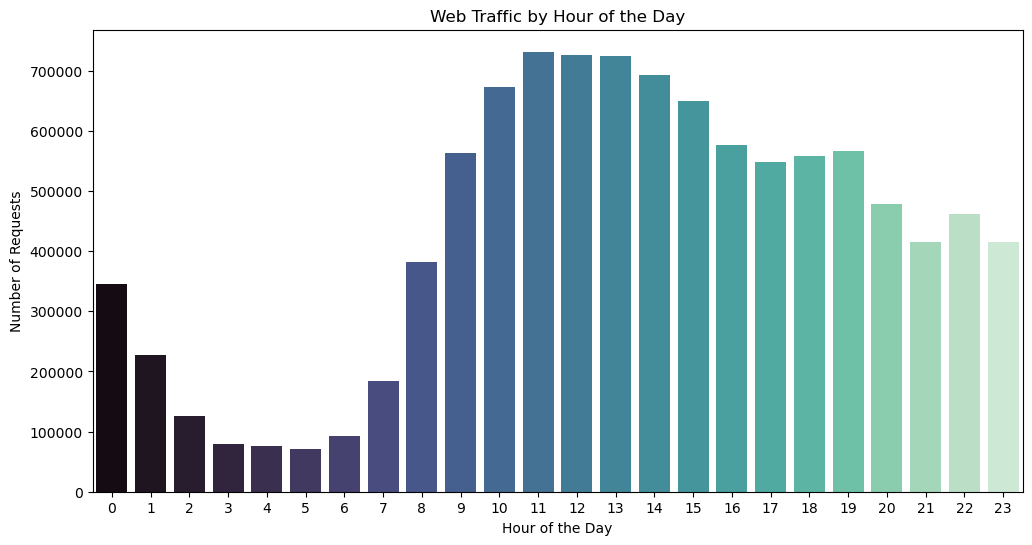

hour_of_day
0     344800
1     227507
2     126406
3      79133
4      76481
5      70670
6      92867
7     184633
8     381551
9     563883
10    672849
11    731595
12    725359
13    724636
14    692415
15    649664
16    575790
17    548896
18    558690
19    566249
20    478687
21    415440
22    462358
23    414585
Name: count, dtype: int64
Column 'client_hostname' does not exist in the DataFrame.


In [ ]:
# Traffic Over Time
merged_df.set_index('time', inplace=True)
traffic = merged_df.resample('H').size()
plt.figure(figsize=(15, 6))
traffic.plot()
plt.title('Web Traffic Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.show()
print(traffic.head())



# Traffic by Day of the Week
merged_df['day_of_week'] = merged_df.index.day_name()
day_counts = merged_df['day_of_week'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=day_counts.index, y=day_counts.values, palette='rocket')
plt.title('Web Traffic by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Requests')
plt.show()

print(day_counts)

# Traffic by Hour of the Day
merged_df['hour_of_day'] = merged_df.index.hour
hour_counts = merged_df['hour_of_day'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette='mako')
plt.title('Web Traffic by Hour of the Day')
plt.xlabel('Hour of the Day')

plt.ylabel('Number of Requests')
plt.show()

print(hour_counts)

# Traffic by Client Hostname
if 'client_hostname' in merged_df.columns:
	client_counts = merged_df['client_hostname'].value_counts().head(10)
	plt.figure(figsize=(12, 6))
	sns.barplot(y=client_counts.index, x=client_counts.values, palette='viridis')
	plt.title('Web Traffic by Client Hostname')
	plt.xlabel('Count')
	plt.ylabel('Client Hostname')
	plt.show()

	print(client_counts)
else:
	print("Column 'client_hostname' does not exist in the DataFrame.")






/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/1951824423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=user_agent_counts.index, x=user_agent_counts.values, palette='magma')


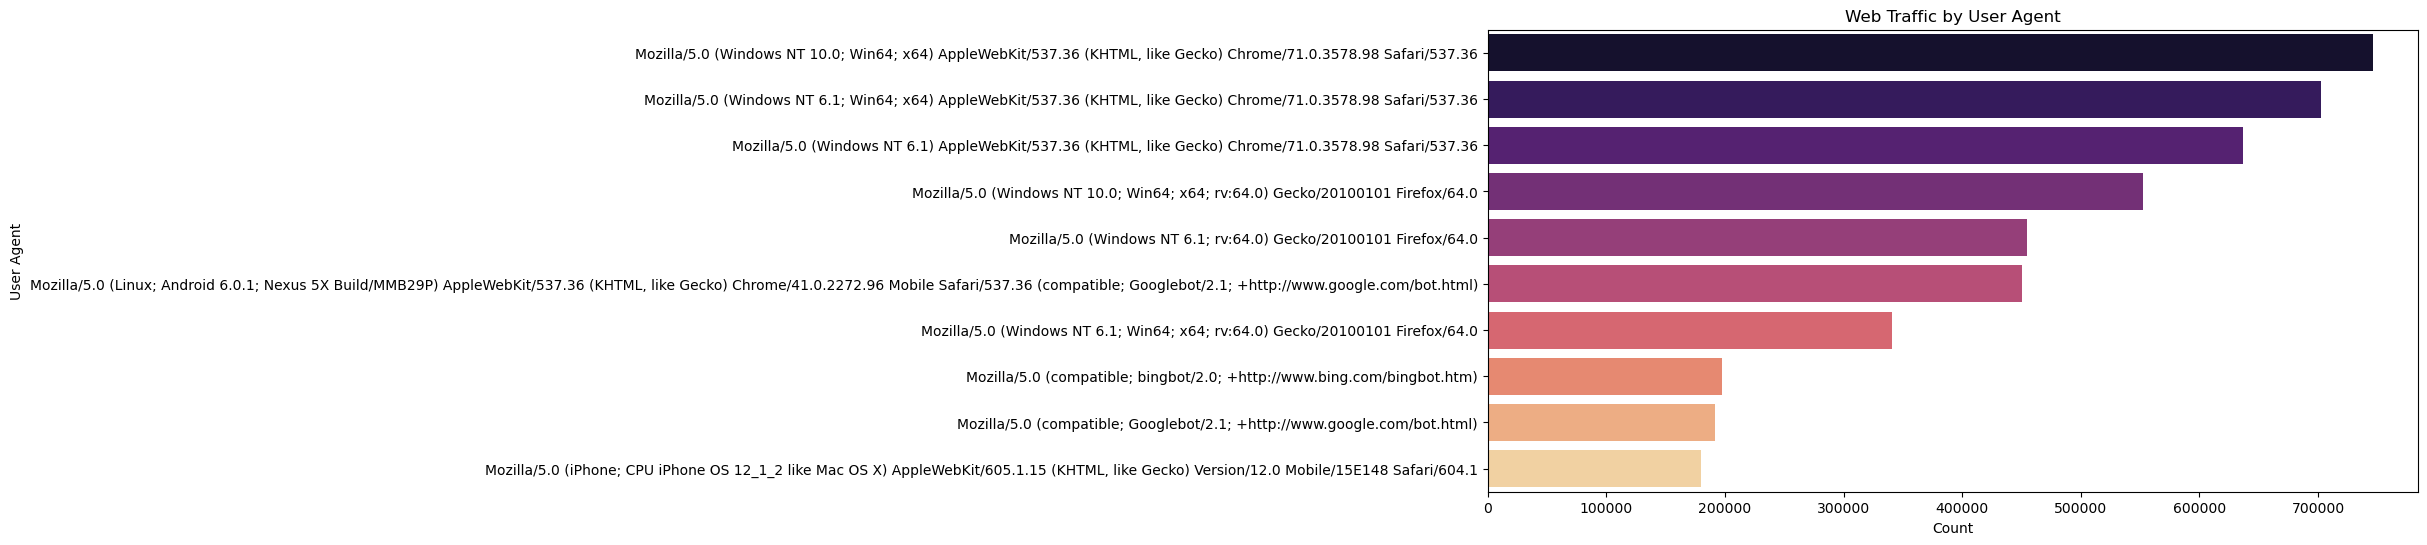

user_agent
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                        746572
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                         702672
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                                     636897
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                                                                                            552142
Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20100101 Firefox/64.0                                                                                        

In [20]:
# Traffic by User Agent
user_agent_counts = merged_df['user_agent'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(y=user_agent_counts.index, x=user_agent_counts.values, palette='magma')
plt.title('Web Traffic by User Agent')
plt.xlabel('Count')
plt.ylabel('User Agent')
plt.show()

print(user_agent_counts)


/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/834203098.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=referer_counts.index, x=referer_counts.values, palette='viridis')


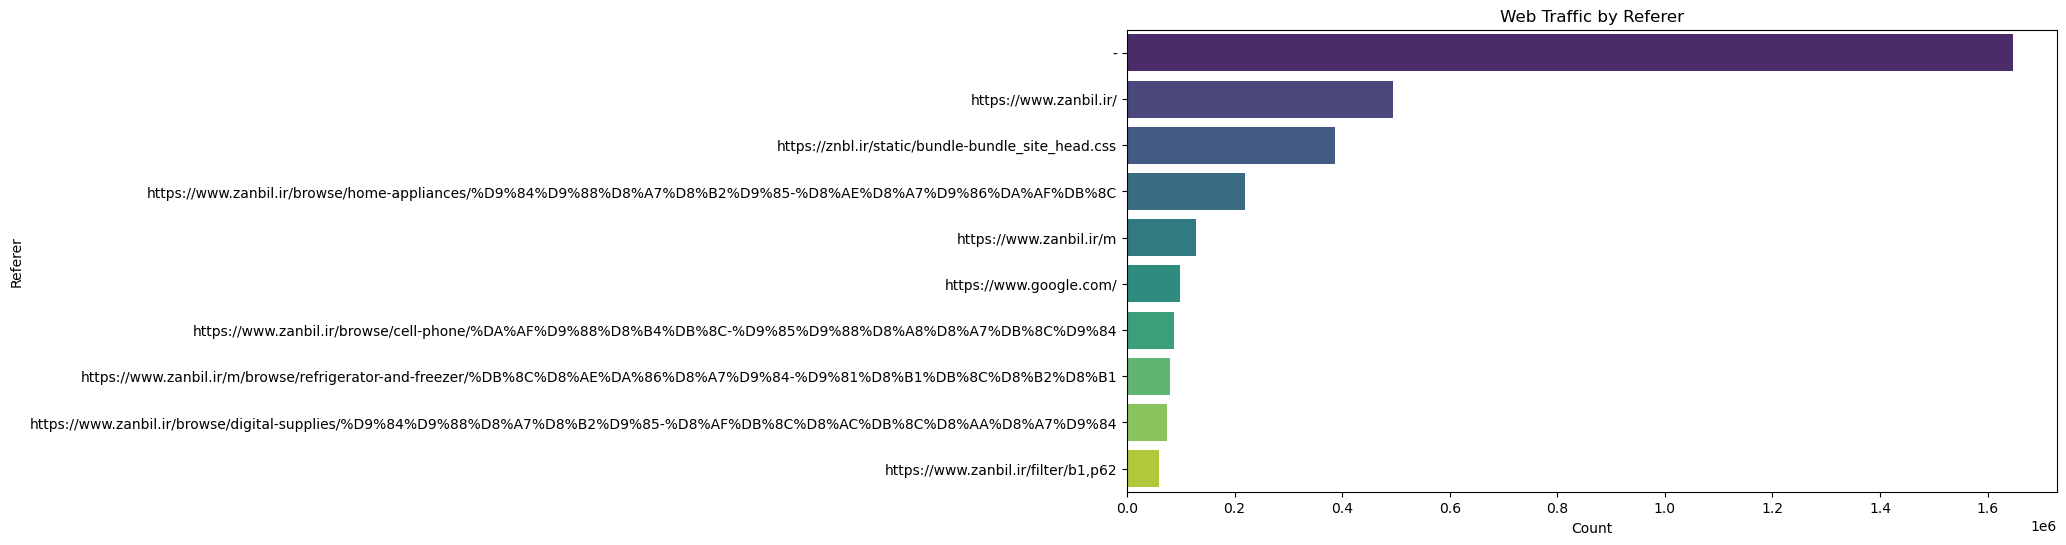

referer
-                                                                                                                          1646351
https://www.zanbil.ir/                                                                                                      494757
https://znbl.ir/static/bundle-bundle_site_head.css                                                                          387201
https://www.zanbil.ir/browse/home-appliances/%D9%84%D9%88%D8%A7%D8%B2%D9%85-%D8%AE%D8%A7%D9%86%DA%AF%DB%8C                  219555
https://www.zanbil.ir/m                                                                                                     128879
https://www.google.com/                                                                                                      98420
https://www.zanbil.ir/browse/cell-phone/%DA%AF%D9%88%D8%B4%DB%8C-%D9%85%D9%88%D8%A8%D8%A7%DB%8C%D9%84                        87726
https://www.zanbil.ir/m/browse/refrigerator-and-freezer/%DB%8C%D8%AE%DA%86%

In [21]:
# Traffic by Referer
referer_counts = merged_df['referer'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(y=referer_counts.index, x=referer_counts.values, palette='viridis')
plt.title('Web Traffic by Referer')
plt.xlabel('Count')
plt.ylabel('Referer')
plt.show()

print(referer_counts)



/var/folders/p2/pt3sjh4571q3w1dl_zmqctrm0000gn/T/ipykernel_7716/610315421.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=ip_counts.index, x=ip_counts.values, palette='mako')


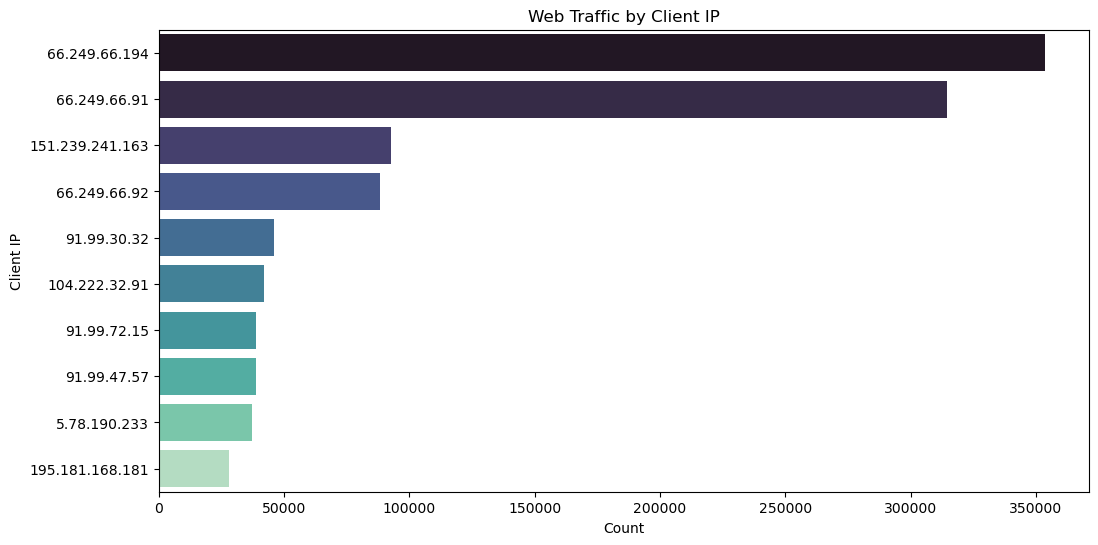

ip
66.249.66.194      353483
66.249.66.91       314522
151.239.241.163     92475
66.249.66.92        88332
91.99.30.32         45979
104.222.32.91       42058
91.99.72.15         38694
91.99.47.57         38612
5.78.190.233        37204
195.181.168.181     27979
Name: count, dtype: int64
Column 'country' does not exist in the DataFrame.
Column 'city' does not exist in the DataFrame.


In [22]:
# Traffic by Client IP
ip_counts = merged_df['ip'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(y=ip_counts.index, x=ip_counts.values, palette='mako')
plt.title('Web Traffic by Client IP')
plt.xlabel('Count')
plt.ylabel('Client IP')
plt.show()

print(ip_counts)


# Traffic by Client Country
if 'country' in merged_df.columns:
    country_counts = merged_df['country'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')
    plt.title('Web Traffic by Client Country')
    plt.xlabel('Count')
    plt.ylabel('Client Country')
    plt.show()

    print(country_counts)
else:
    print("Column 'country' does not exist in the DataFrame.")

# Traffic by Client City
if 'city' in merged_df.columns:
    city_counts = merged_df['city'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(y=city_counts.index, x=city_counts.values, palette='magma')
    plt.title('Web Traffic by Client City')
    plt.xlabel('Count')
    plt.ylabel('Client City')
    plt.show()

    print(city_counts)
else:
    print("Column 'city' does not exist in the DataFrame.")

    

In [24]:
# traffic by client region
if 'region' in merged_df.columns:
    region_counts = merged_df['region'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(y=region_counts.index, x=region_counts.values, palette='viridis')
    plt.title('Web Traffic by Client Region')
    plt.xlabel('Count')
    plt.ylabel('Client Region')
    plt.show()

    print(region_counts)
else:
    print("Column 'region' does not exist in the DataFrame.")
    

Column 'region' does not exist in the DataFrame.


## 5. Feature Engineering



In [27]:
# Function to label user actions:
def label_action(row):
    endpoint = row['endpoint']
    if '/product/view/' in endpoint:
        return 'view_product'
    elif '/cart/add/' in endpoint:
        return 'add_to_cart'
    elif '/purchase/complete/' in endpoint:
        return 'purchase'
    else:
        return 'other'

# Fill NaN values in 'endpoint' column with an empty string
merged_df['endpoint'] = merged_df['endpoint'].fillna('')

merged_df['action'] = merged_df.apply(label_action, axis=1)

print(merged_df['action'].value_counts())



action
other    10365144
Name: count, dtype: int64
